In [37]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os as os
import matplotlib.pyplot as plt

# own code base
import sys

sys.path.append("..")
import tf_loss_functions as lf
import splines as sp

## - Data Preparation

In [38]:
# Spline Hyperparameter

basis_dimension = 20
degree_bsplines = 3
penalty_diff_order = 2


np.random.seed(33)

x1 = np.random.normal(loc=0.0, scale=1, size=400)
x1_df = pd.DataFrame(x1)
x1_df.to_csv(f"./data/df_x1.csv")

x2 = np.random.normal(loc=0.0, scale=1, size=400)

x2_df = pd.DataFrame(x2)
x2_df.to_csv(f"Data/df_x2.csv")


def f(x):
    y = -3 * x**3 + 2 * x**2 + 5 * x  # 3x
    return y


def g(x):
    y = x**5 + 5 * x**2
    return y


error = np.random.normal(loc=0.0, scale=0.5, size=400)  # 0.2

f_x1 = f(x1)
f_x1_df = pd.DataFrame(f_x1)
f_x1_df.to_csv(f"Data/df_f_x1_wiggly.csv")


g_x2 = g(x2)
g_x2_df = pd.DataFrame(g_x2)
g_x2_df.to_csv(f"Data/df_g_x2_wiggly.csv")

labels = f_x1 + g_x2 + error

labels_df = pd.DataFrame(labels)
labels_df.to_csv("Data/df_y_wiggly.csv")


labels_expanded = np.expand_dims(labels, 1)


# create splines from class
x1_ps = sp.pspline(
    x=x1,
    degree_bsplines=degree_bsplines,
    penalty_diff_order=penalty_diff_order,
    knot_type="equi",
    basis_dimension=basis_dimension,
)
x2_ps = sp.pspline(
    x=x2,
    degree_bsplines=degree_bsplines,
    penalty_diff_order=penalty_diff_order,
    knot_type="equi",
    basis_dimension=basis_dimension,
)


lambda_param_x1_est_values = []
lambda_param_x2_est_values = []
gcv_values = []
epochs_saved = []

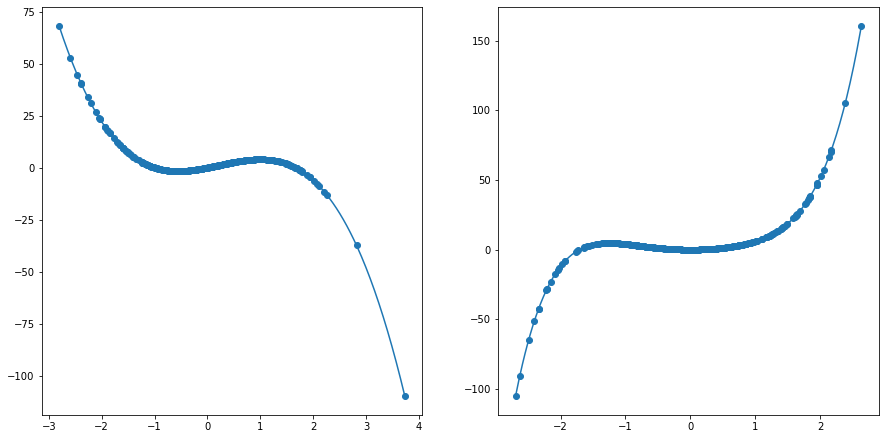

In [39]:
x1_plot = np.linspace(x1.min(), x1.max(), 400)
x2_plot = np.linspace(x2.min(), x2.max(), 400)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
axs[0].plot(x1_plot, f(x1_plot), label="f(x1)")
axs[0].scatter(x1, f_x1)
axs[1].plot(x2_plot, g(x2_plot), label="g(x2)")
axs[1].scatter(x2, g_x2)
fig.set_facecolor("w")
plt.show()

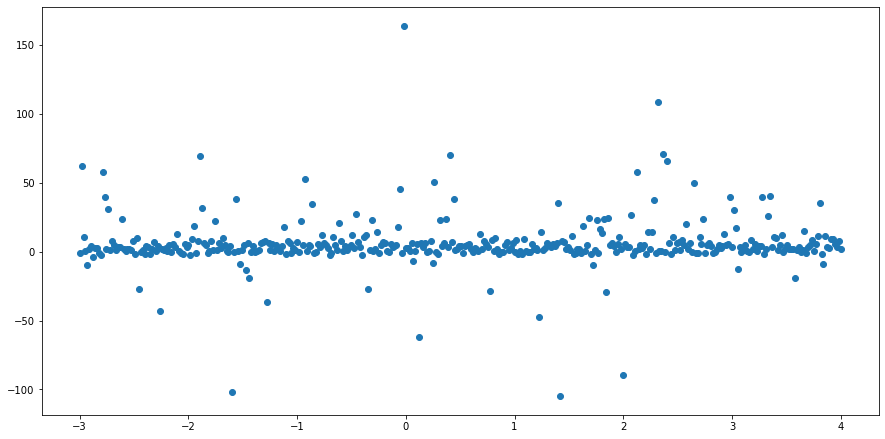

In [40]:
x_plot = np.linspace(-3, 4, 400)

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
ax.scatter(x_plot, labels)
fig.set_facecolor("w")
plt.show()

## - Lambda Initialisierung: Grid Search

In [41]:
# Grid Search
lambda_param_range = np.log10(
    np.float32(np.array([1, 10, 100, 1000, 10000, 100000, 1000000]))
)
gcv_crit_values = []
lambda_param_x1_values = []
lambda_param_x2_values = []

for lambda_x1 in lambda_param_range:
    for lambda_x2 in lambda_param_range:
        value = lf.gcv_2d(
            y=labels_expanded,
            design_matrix_Z_1=x1_ps.design_matrix_d,
            reg_matrix_K_1=x1_ps.penalty_matrix_d,
            reg_param_1=np.exp(lambda_x1),
            design_matrix_Z_2=x2_ps.design_matrix_d,
            reg_matrix_K_2=x2_ps.penalty_matrix_d,
            reg_param_2=np.exp(lambda_x2),
        )

        gcv_crit_values.append(value)
        lambda_param_x1_values.append(lambda_x1)
        lambda_param_x2_values.append(lambda_x2)

crit_values_min = np.min(gcv_crit_values)
lambda_param_x1_init = lambda_param_x1_values[np.argmin(gcv_crit_values)]
lambda_param_x2_init = lambda_param_x2_values[np.argmin(gcv_crit_values)]

# save starting points
epochs_saved.append(0)
lambda_param_x1_est_values.append(lambda_param_x1_init)
lambda_param_x2_est_values.append(lambda_param_x2_init)
gcv_values.append(crit_values_min)

## - Model Building and Optimization

In [42]:
initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=13)

num_epochs_gcv = 5000  # 5000 für gute Approximation
num_epochs_splines = 1


lambda_param_x1 = tf.Variable(
    lambda_param_x1_init, name="lambda_x1", dtype=tf.float32, trainable=True
)
lambda_param_x2 = tf.Variable(
    lambda_param_x2_init, name="lambda_x2", dtype=tf.float32, trainable=True
)


weights_x1 = tf.Variable(
    initializer(shape=(basis_dimension, 1)), name="weights_x1"
)  # shape richtig?
weights_x2 = tf.Variable(
    initializer(shape=(basis_dimension, 1)), name="weights_x2"
)  # shape richtig?


def modelLoss(
    y,
    weights_x1,
    weights_x2,
    lambda_param_x1,
    lambda_param_x2,
    design_matrix_x1,
    penalty_matrix_x1,
    design_matrix_x2,
    penalty_matrix_x2,
):
    y_hat_x1 = tf.matmul(design_matrix_x1, weights_x1)
    y_hat_x2 = tf.matmul(design_matrix_x2, weights_x2)
    prediction = y_hat_x1 + y_hat_x2
    sq_diff = tf.reduce_sum(input_tensor=(y - prediction) ** 2)
    regularizer_x1 = lambda_param_x1 * (
        tf.tensordot(
            tf.transpose(weights_x1),
            tf.tensordot(penalty_matrix_x1, weights_x1, axes=1),
            axes=1,
        )
    )
    regularizer_x2 = lambda_param_x2 * (
        tf.tensordot(
            tf.transpose(weights_x2),
            tf.tensordot(penalty_matrix_x2, weights_x2, axes=1),
            axes=1,
        )
    )
    loss = sq_diff + regularizer_x1 + regularizer_x2
    return loss


opt_splines = tf.keras.optimizers.Adam(learning_rate=0.1)
opt_gcv = tf.keras.optimizers.Adam(learning_rate=0.1)

## - Optimization Loop

In [43]:
for i in range(num_epochs_gcv):
    loss = lambda: lf.gcv_2d(
        y=labels_expanded,
        design_matrix_Z_1=x1_ps.design_matrix_d,
        reg_matrix_K_1=x1_ps.penalty_matrix_d,
        reg_param_1=tf.exp(lambda_param_x1),
        design_matrix_Z_2=x2_ps.design_matrix_d,
        reg_matrix_K_2=x2_ps.penalty_matrix_d,
        reg_param_2=tf.exp(lambda_param_x2),
    )

    opt_gcv.minimize(loss, var_list=[lambda_param_x1, lambda_param_x2])
    pen_loss = loss().numpy().item()

    for j in range(num_epochs_splines):
        loss = lambda: modelLoss(
            y=labels_expanded,
            weights_x1=weights_x1,
            weights_x2=weights_x2,
            lambda_param_x1=tf.exp(lambda_param_x1),
            lambda_param_x2=tf.exp(lambda_param_x2),
            design_matrix_x1=x1_ps.design_matrix_d,
            penalty_matrix_x1=x1_ps.penalty_matrix_d,
            design_matrix_x2=x2_ps.design_matrix_d,
            penalty_matrix_x2=x2_ps.penalty_matrix_d,
        )
        opt_splines.minimize(loss, var_list=[weights_x1, weights_x2])

    if (i + 1) % 100 == 0:
        print(f"Epoch: {i+1}")
        epochs_saved.append(i + 1)
        lambda_param_x1_est = tf.exp(lambda_param_x1).numpy()
        lambda_param_x2_est = tf.exp(lambda_param_x2).numpy()
        lambda_param_x1_est_values.append(lambda_param_x1_est)
        lambda_param_x2_est_values.append(lambda_param_x2_est)
        gcv_values.append(pen_loss)

print(
    f"Final results: \n lambda_param_x1 = {tf.exp(lambda_param_x1).numpy()} \n lambda_param_x2 = {tf.exp(lambda_param_x2).numpy()}"
)

# save final results
epochs_saved.append(num_epochs_gcv)
lambda_param_x1_est = tf.exp(lambda_param_x1).numpy()
lambda_param_x2_est = tf.exp(lambda_param_x2).numpy()
lambda_param_x1_est_values.append(lambda_param_x1_est)
lambda_param_x2_est_values.append(lambda_param_x2_est)
gcv_values.append(pen_loss)


training_frame = pd.DataFrame(
    data=np.array(
        [
            epochs_saved,
            lambda_param_x1_est_values,
            lambda_param_x2_est_values,
            gcv_values,
        ]
    ).T,
    columns=["Epoch", "Lambda Parameter x1", "Lambda Parameter x2", "GCV"],
)
training_frame.to_csv(
    f"Results/Smoothing_param_method=gcv_2d_epochs={num_epochs_gcv}_wiggly.csv"
)

weights_x1_est = np.dot(x1_ps.U, weights_x1.numpy())
weights_x2_est = np.dot(x2_ps.U, weights_x2.numpy())

filename = f"Results/final_spline_method=gcv_2d_epoch={num_epochs_gcv}_wiggly.npz"
np.savez(
    file=filename,
    reg_param_x1=lambda_param_x1_est,
    reg_param_x2=lambda_param_x2_est,
    weights_x1=weights_x1_est,
    weights_x2=weights_x2_est,
)

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Final results: 
 lambda_param_x1 = 3.976666212081909 
 lambda_param_x2 = 0.5206520557403564
